### Manhattan plot creation from Enrichr

In [341]:
import pandas as pd 
import math
import json
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import requests
import time
from operator import itemgetter

Definition of variables whose values will be selected in the appyter

In [342]:
genes = ['TP53', 'TNF', 'EGFR', 'GKN1', 'HADHA', 'APOE', 'ESR1', 'VEGFA', 'TGFB1', 'PREPL', 'TIA1', 'TPO', 'TTN', 'SATB2', 'CHPF', 'MALL', 'MIPIP', 'NUPL1', 'IL6', 'PDIA3', 'CTNNB1', 'SLC39A1', 'DTNA','SLC1A1', 'GALNT2', 'HIST2H2AC', 'CD63']

color = "plum"
enrichr_libraries = ['ChEA_2016', 'GO_Cellular_Component_2017b', 'GeneSigDB']

final_output_file_names = ['output']
figure_file_format = ['png']
legend_location = 'side' # or 'below'
significance_line = '5'

In [343]:
# Function to get Enrichr Results 
# Takes a gene list and Enrichr libraries as input
def Enrichr_API(enrichr_gene_list, all_libraries):

    for library_name in all_libraries : 
        ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/addList'
        genes_str = '\n'.join(enrichr_gene_list)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }

        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')

        data = json.loads(response.text)
        time.sleep(0.5)
        ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        short_id = data["shortId"]
        gene_set_library = library_name
        response = requests.get(
            ENRICHR_URL + query_string % (user_list_id, gene_set_library)
         )
        if not response.ok:
            raise Exception('Error fetching enrichment results')

        data = json.loads(response.text)

        #results_df  = pd.DataFrame(data[library_name][0:5])
        
        results_df  = pd.DataFrame(data[library_name])
        # adds library name to the data frame so the libraries can be distinguished
        results_df['library'] = library_name.replace('_', '')

        # all_terms.append(list(results_df[1]))
        # all_pvalues.append(list(results_df[2]))
        # all_adjusted_pvalues.append(list(results_df[6]))
        # library_names.append(list(results_df['library']))


    return([results_df, str(short_id)])


In [344]:
# Function plots results 

def enrichr_figure():

    if len(enrichr_libraries) == 1:

        results_df = Enrichr_API(genes, enrichr_libraries)[0]

        all_terms = []
        all_pvalues = []

        all_terms.append(list(results_df[1]))
        all_pvalues.append(list(results_df[2]))

        # make a simple scatterplot
        fig, ax = plt.subplots(figsize=(10,4))

        # sort the elements alphabetically
        x=np.log10(all_pvalues[0])*-1
        sorted_terms = list(zip(all_terms[0], x))
        sorted_terms = sorted(sorted_terms, key = itemgetter(0))
        unzipped_sorted_list = list(zip(*sorted_terms))

        data = pd.DataFrame({"Gene Set": unzipped_sorted_list[0], "-log(p value)": unzipped_sorted_list[1]})

        # add significance line and label significant points
        if significance_line != '':
            ax.axes.axhline(y = float(significance_line), color = 'black', lw = 1)

            # label points above the significance line
            point_label = 1
            sig_point_handles = []
            for index, row in data.iterrows():
                if row["-log(p value)"] > float(significance_line):
                    ax.annotate(point_label, xy = (row["Gene Set"], row["-log(p value)"]), xytext=(6, -3), textcoords='offset points')
                    sig_point_handles += [mpatches.Patch(color = 'white', label = str(point_label) + ": " + row["Gene Set"] + ", " + str(round(row["-log(p value)"], 5)))]
                    point_label += 1

            # create a legend for the significant points
            if point_label != 1:
                leg = plt.legend(handles = sig_point_handles, handlelength=0, handletextpad=0, loc='center left', bbox_to_anchor=(1, 0.5), title="Significant Points")
            ax.add_artist(leg)

        ax.scatter(unzipped_sorted_list[0], unzipped_sorted_list[1])
        ax.axes.get_xaxis().set_ticks([])
        plt.ylabel("-log(p value)")
        plt.xlabel(enrichr_libraries[0])

    elif len(enrichr_libraries) > 1:
        # make a manhattan plot

        sorted_data = pd.DataFrame({"Gene Set": [], "-log(p value)": [], "Library": []})
        fig, ax = plt.subplots(figsize=(10,4))

        for i in range(len(enrichr_libraries)):
            # get enrichr results from the library selected
            results_df = Enrichr_API(genes, [enrichr_libraries[i]])[0]

            all_terms = []
            all_pvalues = []
            library_names = []

            all_terms.append(list(results_df[1]))
            all_pvalues.append(list(results_df[2]))
            library_names.append(list(results_df['library']))

            x=np.log10(all_pvalues[0])*-1
            sorted_terms = list(zip(all_terms[0], x, library_names[0]))
            sorted_terms = sorted(sorted_terms, key = itemgetter(0))
            unzipped_sorted_list = list(zip(*sorted_terms))

            data = pd.DataFrame({"Gene Set": unzipped_sorted_list[0], "-log(p value)": unzipped_sorted_list[1], "Library": unzipped_sorted_list[2]})
        
            sorted_data = pd.concat([sorted_data, data])

        # group data by library
        groups = sorted_data.groupby("Library")

        # plot points
        for name, group in groups:
            plt.plot(group["Gene Set"], group["-log(p value)"], marker="o", linestyle="", label=name)

        # remove labels and tick marks on the x-axis
        ax.axes.get_xaxis().set_ticks([])

        # now sort dataframe by p-value
        sorted_data = sorted_data.sort_values(by = ["-log(p value)"], ascending = False)

        # add significance line and label significant points
        if significance_line != '':
            ax.axes.axhline(y = float(significance_line), color = 'black', lw = 1)

            # label points above the significance line
            point_label = 1
            sig_point_handles = []
            for index, row in sorted_data.iterrows():
                if row["-log(p value)"] > float(significance_line):
                    ax.annotate(point_label, xy = (row["Gene Set"], row["-log(p value)"]), xytext=(6, -3), textcoords='offset points')
                    sig_point_handles += [mpatches.Patch(color = 'white', label = str(point_label) + ": " + row["Gene Set"] + ", " + str(round(row["-log(p value)"], 5)))]
                    point_label += 1

            # create a legend for the significant points
            if legend_location == 'side' and point_label != 1:
                leg = plt.legend(handles = sig_point_handles, handlelength=0, handletextpad=0, loc='center left', bbox_to_anchor=(1.5, 0.5), title="Significant Points")
            elif point_label != 1:
                leg = plt.legend(handles = sig_point_handles, handlelength=0, handletextpad=0, loc='center left', bbox_to_anchor=(1, 0.5), title="Significant Points")
            ax.add_artist(leg)

        # adds a legend in the location specified
        if legend_location == 'below':
            # shrink current axis's height by 10% on the bottom
            box = ax.get_position()
            ax.set_position([box.x0, box.y0 + box.height * 0.1,
                            box.width, box.height * 0.9])

            # put a legend below current axis
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
                    fancybox=True, shadow=True, ncol=5)

        elif legend_location == 'side':
            # shrink current axis by 20%
            box = ax.get_position()
            ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

            # put a legend to the right of the current axis
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        plt.ylabel("-log(p value)")

        # save results
    for plot_name in final_output_file_names:
        plt.savefig(plot_name, bbox_inches = 'tight')

    plt.show()

[<matplotlib.patches.Patch object at 0x125ea6c70>, <matplotlib.patches.Patch object at 0x125ea6f40>, <matplotlib.patches.Patch object at 0x125ea6430>, <matplotlib.patches.Patch object at 0x125ea6310>]


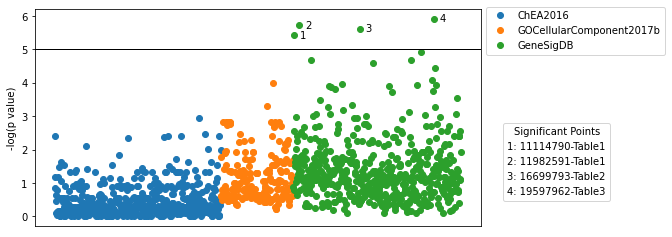

In [345]:
enrichr_figure()